In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`

In [2]:
db_config = {
    'user': '', # имя пользователя
    'pwd': '', # пароль
    'host': '',
    'port': , # порт подключения
    'db': '' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
# напишите запрос
query = '''
SELECT DATE_TRUNC('month', creation_date)::DATE AS month_date,
       SUM(views_count) AS total_views
FROM stackoverflow.posts
WHERE EXTRACT (YEAR FROM creation_date) = 2008
GROUP BY DATE_TRUNC('month', creation_date)
ORDER BY total_views DESC
'''

# выполните запрос
df1 = pd.read_sql_query(query, con=engine) 

In [7]:
df1

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Округлим кол-во просмотров до млн. для удобства просмотра

In [8]:
df1['total_views'] = round(df1['total_views'] / 1000000, 2) 

In [9]:
df1

,month_date,total_views
0,2008-09-01,452.93
1,2008-10-01,365.40
2,2008-11-01,221.76
3,2008-12-01,197.79
4,2008-08-01,131.37
5,2008-07-01,0.67


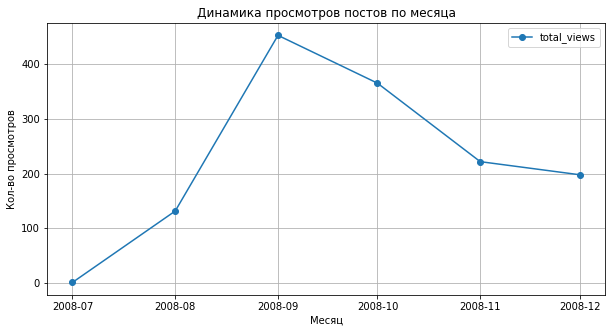

In [10]:
df1.plot(x='month_date', y='total_views', figsize=(10, 5), grid=True, style='-o')
plt.xlabel("Месяц")
plt.ylabel("Кол-во просмотров")
plt.title("Динамика просмотров постов по месяца")
plt.show()   

***Вывод***
* Пиковое кол-во просмотров пришлось на сентябрь месяц 452 млн. просмотров - это может быть связанно с началом учебного года и с всплеском активности студентов и школьников, далее кол-во просмотров стагнировало до 197 млн. просмотров к декабрю - это может быть связано с угасанием активности студентов и школьников и близостью новогодних каникул;
* Так же летние месяцы являются самым популярным периодом для отпусков, в следствие чего активность сильно снижается - этот фактор мог негативно повлиять на кол-во просмотров постов.

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [11]:
# напишите запрос
query = '''
SELECT display_name,
       COUNT(id)
FROM stackoverflow.users
WHERE display_name IN 
                   (SELECT us.display_name
                    FROM stackoverflow.users AS us
                    JOIN stackoverflow.posts AS p ON us.id = p.user_id
                    WHERE post_type_id IN (SELECT id
                                           FROM stackoverflow.post_types
                                           WHERE type = 'Answer') AND
                          p.creation_date < us.creation_date + '30 day'
                    GROUP BY us.display_name
                    HAVING COUNT(p.id) > 100)
GROUP BY display_name
ORDER BY display_name;
'''

# выполните запрос
df2 = pd.read_sql_query(query, con=engine) 

In [12]:
df2.head(10)

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,11
5,Amy B,1
6,Ben Hoffstein,1
7,Brian,27
8,Cade Roux,1
9,CesarB,1


***Вывод***

* Некоторые имена пользователей повторяются многократно, возможны следующие причины данных аномалий: разные пользователи регистрируются под одним и тем же именем (например имя Brain), один и тот же пользователь зарегистрировался несколько раз.

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [13]:
# напишите запрос
query = '''
SELECT DATE_TRUNC('month', creation_date)::DATE AS month,
       COUNT(id)
FROM stackoverflow.posts
WHERE user_id IN (SELECT DISTINCT us.id
                  FROM stackoverflow.users AS us
                  JOIN stackoverflow.posts AS p ON us.id = p.user_id
                  WHERE DATE_TRUNC('month', us.creation_date) = '2008-09-01' AND
                        DATE_TRUNC('month', p.creation_date) = '2008-12-01')
GROUP BY month
ORDER BY month DESC
'''

# выполните запрос
df3 = pd.read_sql_query(query, con=engine)

In [14]:
df3

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


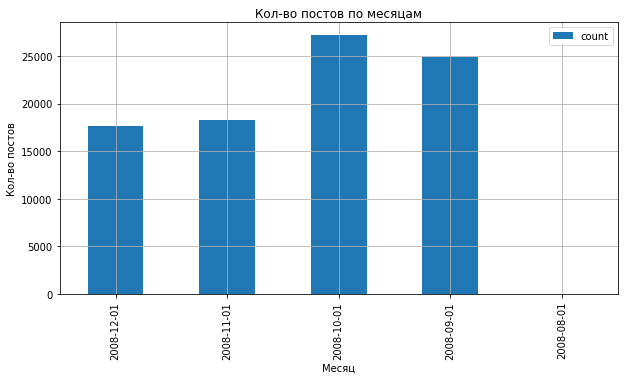

In [15]:
df3.plot(x='month', y='count', figsize=(10, 5), grid=True, style='-o', kind='bar')
plt.xlabel("Месяц")
plt.ylabel("Кол-во постов")
plt.title("Кол-во постов по месяцам")
plt.show()   

***Выводы***

* Обнаружена анамолия: существует 32 поста за август месяц, хотя пользователи отобраны с регистрацией в сентябре месяцы;
* Наибольшую активность пользователи проявляют в первые два месяца, после регистрации, потом идёт спад активности.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [16]:
# напишите запрос
query = '''
SELECT us.id,
       p.creation_date,
       p.views_count,
       SUM(p.views_count) OVER(PARTITION BY us.id ORDER BY p.creation_date)
FROM stackoverflow.users AS us
JOIN stackoverflow.posts AS p ON us.id = p.user_id
ORDER BY us.id
'''

# выполните запрос
df4 = pd.read_sql_query(query, con=engine)

In [17]:
df4

,id,creation_date,views_count,sum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [18]:
# напишите запрос
query = '''
SELECT us.id,
       COUNT(p.id) / COUNT(DISTINCT DATE_TRUNC('day', p.creation_date))::FLOAT AS avg_daily
FROM stackoverflow.users AS us
JOIN stackoverflow.posts AS p ON us.id = p.user_id
WHERE DATE_TRUNC('day', p.creation_date) IN (SELECT DATE_TRUNC('day', creation_date)::DATE
                                             FROM stackoverflow.posts
                                             WHERE DATE_TRUNC('month', creation_date) = '2008-08-01'
                                             GROUP BY DATE_TRUNC('day', creation_date)
                                             HAVING COUNT(id) != 0)
GROUP BY us.id
HAVING COUNT(p.id) > 120
ORDER BY avg_daily
'''

# выполните запрос
df5 = pd.read_sql_query(query, con=engine)

In [19]:
df5

,id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [20]:
# напишите запрос
query = '''
SELECT ROUND(COUNT(id)/COUNT(DISTINCT id)::FLOAT)     
FROM (SELECT us.id AS id,
             DATE_TRUNC('day', p.creation_date)::DATE,
             COUNT(p.id) AS count_post
      FROM stackoverflow.users AS us
      JOIN stackoverflow.posts AS p ON us.id = p.user_id
      WHERE DATE_TRUNC('day', p.creation_date) BETWEEN '2008-12-01' AND '2008-12-07'
      GROUP BY us.id, DATE_TRUNC('day', p.creation_date)
      HAVING COUNT(p.id) != 0) AS interaction
'''
# выполните запрос
df6 = pd.read_sql_query(query, con=engine)

In [21]:
# напишите ваш ответ здесь
df6

,round
0,2.0


***Вывод***
* В среднем пользователи взаимодействовали с платформой два дня в период с 1 по 7 декабря 2008 года.

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [22]:
# напишите запрос
query = '''
SELECT us.id AS id,
       p.creation_date,
       LAG(TO_CHAR(p.creation_date, 'month'), 2) OVER(PARTITION BY us.id ORDER BY p.creation_date)
FROM stackoverflow.users AS us
JOIN stackoverflow.posts AS p ON us.id = p.user_id
'''

# выполните запрос
df7 = pd.read_sql_query(query, con=engine)

In [23]:
df7.head(10)

,id,creation_date,lag
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,july
3,1,2008-08-04 02:45:08,july
4,1,2008-08-04 04:31:03,july
5,1,2008-08-04 08:04:42,august
6,1,2008-08-10 08:28:52,august
7,1,2008-08-11 19:23:47,august
8,1,2008-08-12 00:30:43,august
9,1,2008-08-12 04:59:35,august


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [24]:
# напишите запрос
query = '''
WITH profile AS
  (SELECT user_id,
          DATE_TRUNC('month', start_dt) AS dt,
          COUNT(*) OVER (PARTITION BY DATE_TRUNC('month', start_dt)) AS cohort_users_cnt
   FROM 
     (SELECT user_id,
             MIN(creation_date) OVER (PARTITION BY user_id) AS start_dt
      FROM stackoverflow.posts) AS T
   GROUP BY user_id,
            dt),
sessions AS
  (SELECT DISTINCT user_id,
          DATE_TRUNC('month', creation_date) AS session_date
   FROM stackoverflow.posts)
SELECT p.dt AS cohort_dt,
       s.session_date,
       COUNT(p.user_id) AS users_cnt,
       p.cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / p.cohort_users_cnt, 2) AS retention_rate
FROM profile p
JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1,
         2,
         4;
'''

# выполните запрос
df8 = pd.read_sql_query(query, con=engine)

In [25]:
df8

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


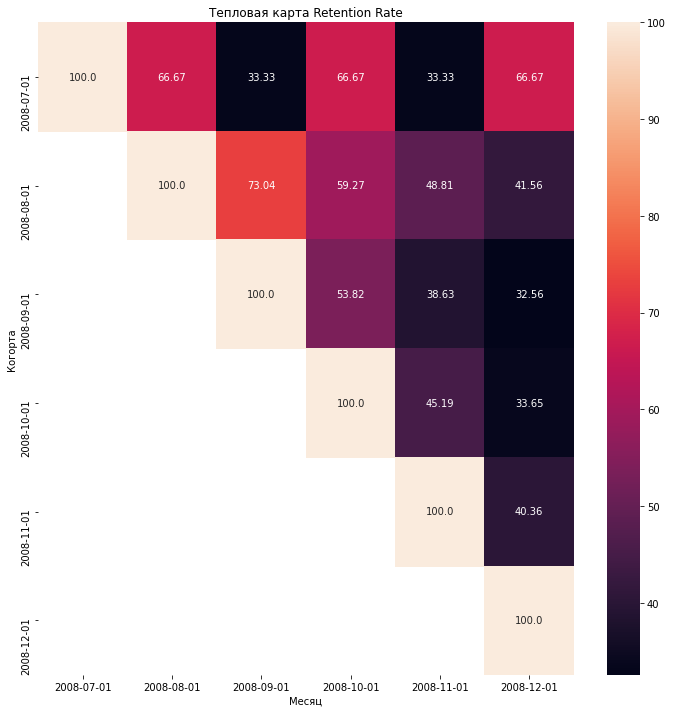

In [26]:
# тепловая карта Retention Rate
retention = df8.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(12, 12)) 
sns.heatmap(retention, annot=True, fmt='')
plt.title('Тепловая карта Retention Rate')
plt.xlabel("Месяц")
plt.ylabel("Когорта")
plt.show() 

На первую когорту (07.2008) не обращаем внимание, так как туда попали всего трое пользователей

***Выводы***
* В сентябре произошёл резкий всплеск: 7678 пользователей написали свой первый пост, в сравнение с 2151 в августе, после сентября пошло резкое угасание: 3629 - в октябре, 2852 - в ноябре и 2536 - в декабре. Возможно в сентябре проводилась активная рекламная компания, которая привлекла много новых пользователей, а в последующие месяцы эффект от рекламной компании постепенно угасал;
* Retention Rate падает быстрее в каждой последующей когорте, во втором месяцы у второй когорты CRR=73,04, а у пятой когорты уже всего лишь 40,36. Возможно, в начале на платформу приходили пользователи, которые сами нашли проект и были более в нём заинтересованны, а далее приходило много пользователей привлеченных благодаря рекламной компании и они менее заинтересованны в платформе. Возможно, пользователи в разные месяцы привлекались по разным каналам и канал во втором месяцы был самым удачнам по показателю Retention Rate, в этот месяц приходили наболее заинтересованный в платформе пользователи.

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [27]:
# напишите запрос
query = '''
SELECT creation_month,
       posts_count,
       ROUND((posts_count - LAG(posts_count, 1) OVER ()) * 100.0 /  LAG(posts_count, 1) OVER (), 2) AS percentage
FROM 
   (SELECT EXTRACT (MONTH FROM creation_date)::INT AS creation_month,
           COUNT(id) AS posts_count
    FROM stackoverflow.posts
    WHERE DATE_TRUNC('month', creation_date) BETWEEN '2008-09-01' AND '2008-12-01'
    GROUP BY creation_month
    ORDER BY creation_month) AS P
'''
# выполните запрос
df9 = pd.read_sql_query(query, con=engine)

In [28]:
df9

,creation_month,posts_count,percentage
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


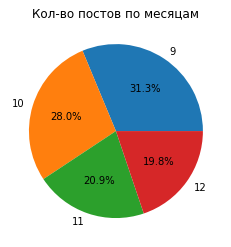

In [29]:
# постройте круговую диаграмму с количеством постов по месяцам
plt.pie(df9['posts_count'], labels=df9['creation_month'], autopct='%1.1f%%')
plt.title("Кол-во постов по месяцам")
plt.show() 

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [30]:
# напишите запрос
query = '''
SELECT DISTINCT EXTRACT(WEEK FROM creation_date)::INT AS week_creation,
       MAX(creation_date) OVER (PARTITION BY EXTRACT(WEEK FROM creation_date))
FROM stackoverflow.posts
WHERE DATE_TRUNC('month', creation_date) = '2008-10-01' AND
      user_id = (SELECT user_id
                 FROM 
                   (SELECT user_id,
                           COUNT(id),
                           ROW_NUMBER() OVER(ORDER BY COUNT(id) DESC) AS rn
                    FROM stackoverflow.posts
                    GROUP BY user_id) AS TOP
                 WHERE rn = 1)
'''
# выполните запрос
df10 = pd.read_sql_query(query, con=engine)

In [31]:
df10

,week_creation,max
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01
